In [1]:
import rebound, numpy as np, matplotlib as mpl
#mpl.use('Agg') # found here:https://stackoverflow.com/questions/4931376/generating-matplotlib-graphs-without-a-running-x-server
import matplotlib.pyplot as plt, time as tiempo, math, sys

import subprocess 
def ding(): 
    """
    This is sometimes added to the end of code that takes a long time to run,
    so that I know when it is completed.
    It requires an mp3 file named "ding.mp3" in the same directory as this file.
    """
    subprocess.call(["afplay","ding.mp3"])

sim = rebound.Simulation()
tau = 2*np.pi

In [6]:
def ttor(R0 = 5e-4): #two to one resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 5**(1/3)*0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=2**(2/3), f=np.pi, r=R0) 
    return sim

def tttr(R0 = 5e-4): #two to three resonance
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    #R0 = 0.01
    sim.add(m=1) #creates a star of mass 1
    sim.add(m=1e-3, a=2**(2/3), r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=3**(2/3), f=np.pi, r=R0) 
    return sim

def nor(R0 = 5e-4): #no resonance (initially at least)
    sim = rebound.Simulation()
    #sim.units = ('yr', 'AU', 'Msun') #sets G=4pi^2 so AU, earth years, solar masses
    sim.add(m=1) #creates a star of mass 1
    #R0 = .02
    sim.add(m=1e-3, a=1, r=R0)  #creates a planet with mass 0.001 at 1 AU
    sim.add(m=1e-3, a=1.8, f=np.pi, r=R0) #use .1 mass to show the planets having a large effect on each other
    return sim
    
def resonance_counter(data, base = 1): # data should be realtive x values or y values
    innerplanetcount = 0
    outerplanetcount = 0
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        if x[0] < 0 and data[i+1][0] > 0:
            innerplanetcount += 1
        if x[1] < 0 and data[i+1][1] > 0:
            outerplanetcount += 1
    R = innerplanetcount/outerplanetcount
    print(R)
    R = R*base
    if R == int(R):
        R = int(R)
    print("The outer planet revolved", outerplanetcount, "times.")
    print("The inner planet revolved", innerplanetcount, "times.")
    print("They are in a {}:{} resonance.".format(base, R))
     
def rand_powerlaw(slope, min_v, max_v): #some distribution functions
    #https://rebound.readthedocs.io/en/latest/ipython/PrimordialEarth.html
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))
def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum
def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def quickplot(sim): #this uses matplotlib to plot the orbit, instead of rebound
    coords = np.zeros((2,sim.N))
    for i in range(sim.N):
        coords[0][i], coords[1][i] = sim.particles[i].x, sim.particles[i].y
    fig, ax = plt.subplots()
    ax.axis('equal')
    ax.scatter(coords[0],coords[1],marker=".",linewidth=0)
    for i in range(sim.N_active):
        ax.scatter(sim.particles[i].x,sim.particles[i].y); # Planet
        
def my_merge(sim_pointer, collided_particles_index):
    
    #https://rebound.readthedocs.io/en/latest/ipython/User_Defined_Collision_Resolve.html
    #or
    #https://rebound.readthedocs.io/en/latest/ipython_examples/User_Defined_Collision_Resolve/
    
    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i1 = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.
    j1 = collided_particles_index.p2
    
    if ps[i1]==0 and ps[j1]==0:
        return 0
    else:
        if ps[i1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=j1
            l=i1
            destroyi1=True
        if ps[j1].m==0: #assigns k as the planet with mass and l as the particle w/o mass
            k=i1
            l=j1
            destroyi1=False
            
        '''fig, ax = rebound.OrbitPlot(sim, xlim = (-1.3, 1.3), ylim = (-1.3, 1.3), color=['blue', 'green'])
        ax.set_title("Merging particle {} into {}".format(j, i))
        ax.text(ps[k].x, ps[k].y, "1");
        ax.text(ps[l].x, ps[l].y, "2")'''
        # So we plot the scenario exactly at the timestep that the collision function is triggered
        
        #print("merging particle", k,'into particle', l) #use this to know when collisions occur
        
        #particle_mass = Mtot_disk/N_pl
        particle_mass=1e-5
        particle_radius = 1e-5
        # Merging Logic
        total_mass = ps[k].m + particle_mass
        #merged_planet = (ps[i] * ps[i].m + ps[j] * ps[j].m)/total_mass # conservation of momentum

        # merged radius assuming a uniform density
        merged_radius = (ps[k].r**3 + particle_radius**3)**(1/3)

        #ps[k] = merged_planet   # update p1's state vector (mass and radius will need corrections)
        ps[k].m = total_mass    # update to total mass
        ps[k].r = merged_radius # update to joined radius
        
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1 #after adding mass
        #to a particle, we must recalculate Jacobi coordinates in order to recieve
        #physical values. Note that this code should be commented out if safemode is on.
        
        if destroyi1:
            return 1 #destroys p1, which is the particle w/o mass
        else:
            return 2 #destroys p2, which is the particle w/o mass
     
    
def masslist_txt(masslist,filepath,sim = None, write_type = 'a'):
    """
    Saves the masslists into a formatted txt file.
    """
    
    def avg(lst):
        sum = 0
        for i in lst:
            sum += i
        return sum / len(lst)

    masslistcopy = masslist.copy() # Don't want to edit the original data
    percentlist = list()
    message = ''
    message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        percentlist.append(percentdif)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'   
    message+= "\nAverage percent difference= {}.\n\n".format(avg(percentlist))
    with open(filepath,write_type) as file:
        file.write(sim+'\n')
        file.write(message)
        
def masslist_txt_append(masslist, filepath,sim = None,write_type = 'a', **kwargs):
    """
    Saves the masslists into a formatted txt file. This is similar to masslist_txt except 
    it lends itself better to appending. It is meant for simulations ran entirely separately.
    """
    
    def avg(listt):
        sum = 0
        for i in listt:
            sum += i
        return sum / len(listt)
    
    masslistcopy = masslist.copy() # Don't want to edit the original data
    message = ''
    if kwargs.get('first'):
        write_type = "w"
        message += sim+'\n'
        message+="Inner planet mass\tOuter planet mass\tPercent Difference\tSeed\n"
    for data in masslistcopy[1:]:
        #data = data.copy() #comment out this line to not have the original list change
        percentdif = abs((data[0]-data[1])/data[0])*100
        roundedpercentdif = round(percentdif,2)
        data.insert(2,percentdif)
        for j in data:
            message += str(j)
            message +='\t'
        message +='\n'
    with open(filepath,write_type) as file:
        file.write(message)
    if kwargs.get('last'):
        with open(filepath, "a") as file:
            file.write("\nAverage percent difference: {}"
                       .format(averagePercent(filepath)))
            file.write("\n"+"#"*40)
        
def masslist_read(filePath):
    """
    Inverse of masslist_txt()
    """
    with open(filePath,'r') as datafile:
        contents = datafile.read()
    contents = contents.split()
    finalList = []
    for index,value in enumerate(contents):
        try:
            value = float(value)
            finalList.append(value)
        except:
            pass
    return finalList

def avg(listt, **kwargs):
    sum = 0
    length = len(listt)
    if kwargs.get('positive'):
        for i in listt:
            if i > 0:
                sum += i
            else:
                length -= 1
        return sum / length
    if kwargs.get('nonNegative'):
        for i in listt:
            if i >= 0:
                sum += i
            else:
                length -= 1
        return sum / len(listt)
    for i in listt:
        sum += i
    return sum / len(listt)

def averagePercent(filePath):
    dataList = masslist_read(filePath)
    percentList = []
    for i in range(2,len(dataList),4):
        percentList.append(dataList[i])
    return avg(percentList)

def saveFigs(addOn = "", seed = 0, **kwargs):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    if kwargs.get("test"):
        seed = "Tests"
    
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/Eccentricity"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+str(seed)+"/relativeXValue"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+str(seed)+"/masses"+addOn+".pdf")
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    plt.title('Asteroid Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccs')
    plt.savefig("Figures/"+str(seed)+"/RoidEccs"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(EccsList, nonNegative = True) for EccsList in asteroidEccs],linewidth=1)
    plt.title('Asteroid Eccentricity AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/RoidEccsAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins = 30
    plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
    plt.title("Asteroids Final Eccentricity Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxis"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(asteroidAUList,positive=True) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins =30
    plt.hist([data for data in asteroidAU[0] if data > 0 and data < 5], num_bins)
    plt.title("Asteroids Beginning Semi Major Axis Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoStart"+addOn+".pdf")
    
    plt.clf()
    plt.hist([data for data in asteroidAU[-1] if data > 0 and data < 5], num_bins)
    plt.title("Asteroids Ending Semi Major Axis Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoEnd"+addOn+".pdf")

In [3]:
def generatettor(simulation = ttor,seed = None, asteroidnumber = 1000):  
    sim = simulation()
    sim.N_active = sim.N

    sim.integrator = "ias15"
#     sim.integrator = "mercurius"
    #sim.ri_mercurius.hillfac = 3
    #sim.ri_ias15.min_dt = 0 # stes the minimum dt, default is 0. This should be specified on mercurius as well.
    #sim.integrator = "whfast"
    #sim.ri_whfast.corrector = 0 #zero order corrector for better speed
    #sim.ri_whfast.safe_mode = 0 #turns off safemode, *substantial* speed boost
    #sim.dt = 0.001*2*np.pi #mutiple by 2pi if in units such that G=1
    sim.testparticle_type = 0
    #sim.ri_ias15.min_dt = 1e-6 # ensure that close encounters do not stall the integration

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = my_merge # a function that I made
    sim.collision_resolve_keep_sorted = 1
    sim.boundary = "open"
    boxsize = 100
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1

    N_pl = asteroidnumber                # Number of planetesimals
    Mtot_disk = 10*sim.particles[1].m    # Total mass of planetesimal disk
    m_pl = 0 #Mtot_disk / float(N_pl)    # Mass of each planetesimal
    r_pl = 2e-9 

    #seed = 0
    #46 is my most frequently used seed
    np.random.seed(seed) # by setting a seed we will reproduce the same simulation every time
    while sim.N < (N_pl + sim.N_active):
        #a = rand_powerlaw(0, 0.1, 3) 
        a = rand_uniform(.6,2.9)
        #e = rand_rayleigh(0.01) by default is 0
        e=0
        #inc = rand_rayleigh(0.005)
        inc=0
        f = rand_uniform(-np.pi,np.pi)
        p = rebound.Particle(simulation=sim,primary=sim.particles[0], r=r_pl, a=a, e=e, inc=inc, Omega=0, omega=0, f=f)
        # Only add planetesimal if it's far away from the planet
        d1 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[1].xyz))
        d2 = np.linalg.norm(np.array(p.xyz)-np.array(sim.particles[2].xyz))
        d = min(d1,d2)
        if d>5e-4:
            sim.add(p)
    
    # Hash Creation
    ps = sim.particles
    ps[0].hash = "star"
    ps[1].hash = "innerPlanet"
    ps[2].hash = "outerPlanet"
    for i in range(3,sim.N): # this sets their hash to their starting particle number
        ps[i].hash = str(i)
    #

    sim.collision_resolve = my_merge

    #sim.move_to_com()
    E0 = sim.calculate_energy()
    #quickplot(sim)
    return sim
    
def quickcollect2(n, Ti, Tf, stepnumber, **kwargs): #collects orbital data on the first two bodies in a system
    initialtime = tiempo.monotonic()
#     n=2 #number of planets
#     T=80*2*np.pi #years of simulation
    # Planet variables
    global times, dist, relative_x_value,relative_y_value, eccs, position1, position2, \
    interplanetdistance, masses, particleNumber
    times = np.linspace(Ti,Tf,stepnumber)
    #diftimes = list()
    dist = np.zeros((len(times),n)) 
    relative_x_value = np.zeros((len(times),n))
    relative_y_value = np.zeros((len(times),n))
    eccs = np.zeros((len(times),n))
    position1 = np.zeros((len(times),2))
    position2 = np.zeros((len(times),2))
    interplanetdistance = np.zeros((len(times),1))
    particleNumber = np.zeros((len(times),1))
    masses = np.zeros((len(times),n))
    ps = sim.particles
    # Asteroid variables:
    global asteroidAU, asteroidEccs, simNi
    simNi = sim.N
    asteroidAU = np.zeros((len(times),simNi-n-1)) # n is the number of planets, 1 is the number of stars
    asteroidEccs = np.negative(np.ones((len(times),simNi-n-1)))
    for i, t in enumerate(times):
        sim.integrate(t)
        print("| {} time = {} years | {} particles | {} step number |\n\
| {} second | {} minutes.\n"\
        .format(t,t/tau,sim.N,i,round((tiempo.monotonic()-initialtime),1)\
        ,round((tiempo.monotonic()-initialtime)/60,1)))
        #sim.ri_whfast.recalculate_coordinates_this_timestep = 1
        #sim.integrator_synchronize()
        #diftimes.append(sim.t+dT)
        #if i== int(stepnumber/2):
            #print("1/2 done at {} seconds.".format(int(tiempo.time() - initialtime)))
        ps = sim.particles
        interplanetdistance[i] = np.linalg.norm(np.array(ps[2].xyz)-np.array(ps[1].xyz))
        particleNumber[i] = sim.N
        position1[i] = [ps[1].x,ps[1].y]
        position2[i] = [ps[2].x,ps[2].y]
        for planet in range(n):
            planetdif = planet+1
            dist[i,planet] = np.linalg.norm(np.array(ps[planetdif].xyz)-np.array(ps[0].xyz))
            relative_x_value[i,planet] = ps[planetdif].x - ps[0].x
            relative_y_value[i,planet] = ps[planetdif].y - ps[0].y
            eccs[i,planet] = ps[planetdif].e
            masses[i,planet] = ps[planetdif].m
        position1[i] = [relative_x_value[i,0],relative_y_value[i,0]]
        position2[i] = [relative_x_value[i,1],relative_y_value[i,1]]
        #### Data collection from asteroids:
        if kwargs.get("asteroidCollect"):
            for roidNumber in range(3,simNi):
                #print("index:{}, roidNumber: {}".format(index,roidNumber))
                index = roidNumber - n -1
                try:                    
                    asteroidAU[i,index] = ps[str(roidNumber)].a
                    asteroidEccs[i,index] = ps[str(roidNumber)].e
                except:
                    pass
        ####
    finaltime = tiempo.monotonic()
#     print('done')
    #print("{} done at {} seconds!".format((a+1)/10,int(finaltime-initialtime)))
    print("Done at {} seconds!".format((int(finaltime-initialtime))))
#     print("The inner planet ended with a mass of {}.".format(ps[1].m))
#     print("The outer planet ended with a mass of {}.".format(ps[2].m))
#     print("There are {} particles remaining.".format(sim.N))
    quickplot(sim)
    #ding()
    
def remove(AU, sim = sim):
    for i in reversed(range(sim.N)):
        ps = sim.particles
        if np.linalg.norm(np.array(ps[i].xyz)-np.array(ps[0].xyz)) > AU:
            sim.remove(i)

Steps: 100
Beginning seed 0.
| 0.0 time = 0.0 years | 103 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 6.346651825433926 time = 1.0101010101010102 years | 103 particles | 1 step number |
| 0.1 second | 0.0 minutes.

| 12.693303650867852 time = 2.0202020202020203 years | 103 particles | 2 step number |
| 0.2 second | 0.0 minutes.

| 19.039955476301778 time = 3.0303030303030303 years | 103 particles | 3 step number |
| 0.3 second | 0.0 minutes.

| 25.386607301735705 time = 4.040404040404041 years | 103 particles | 4 step number |
| 0.4 second | 0.0 minutes.

| 31.73325912716963 time = 5.050505050505051 years | 102 particles | 5 step number |
| 0.6 second | 0.0 minutes.

| 38.079910952603555 time = 6.0606060606060606 years | 102 particles | 6 step number |
| 0.6 second | 0.0 minutes.

| 44.426562778037486 time = 7.070707070707072 years | 102 particles | 7 step number |
| 0.7 second | 0.0 minutes.

| 50.77321460347141 time = 8.080808080808081 years | 102 particles | 8 step nu

| 463.3055832566766 time = 73.73737373737374 years | 96 particles | 73 step number |
| 6.1 second | 0.1 minutes.

| 469.6522350821105 time = 74.74747474747475 years | 96 particles | 74 step number |
| 6.2 second | 0.1 minutes.

| 475.9988869075445 time = 75.75757575757576 years | 96 particles | 75 step number |
| 6.3 second | 0.1 minutes.

| 482.3455387329784 time = 76.76767676767678 years | 96 particles | 76 step number |
| 6.3 second | 0.1 minutes.

| 488.69219055841234 time = 77.77777777777779 years | 96 particles | 77 step number |
| 6.4 second | 0.1 minutes.

| 495.03884238384626 time = 78.7878787878788 years | 96 particles | 78 step number |
| 6.4 second | 0.1 minutes.

| 501.3854942092802 time = 79.7979797979798 years | 96 particles | 79 step number |
| 6.5 second | 0.1 minutes.

| 507.7321460347141 time = 80.80808080808082 years | 96 particles | 80 step number |
| 6.5 second | 0.1 minutes.

| 514.078797860148 time = 81.81818181818183 years | 96 particles | 81 step number |
| 6.

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

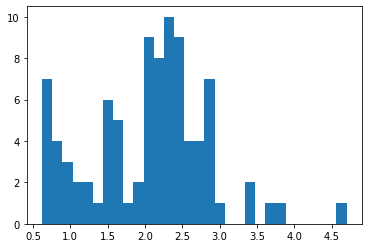

In [37]:
numberOfSims = 1 
endTime = 100 #years of simulation
ttor_masses = [['inner planet mass', 'outer planet mass','seed']]
BIGinitial = tiempo.monotonic()
# try:
#     a = int(sys.argv[1])
# except IndexError:
#     print("#"*40)
#     print("\n"*3)
#     print("Sys.argv had an error! Setting the seed equal to 0!")
#     print("\n"*3)
#     print("#"*40)
a = 0
#
#for a in range(numberOfSims):
stepFrequency = 1 # how often should a step occur (years)
steps = int(endTime/stepFrequency) # Will round down to an integer
print(f"Steps: {steps}")
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 100)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = steps, asteroidCollect = True)
print("Masses {} and {}.".format(ps[1].m,ps[2].m))
print("Ending seed {}.\n".format(a))
pre_list = [ps[1].m, ps[2].m,a]
ttor_masses.append(pre_list)
#
BIGfinal = tiempo.monotonic()
totaltime = BIGfinal - BIGinitial
print("That in total took {} seconds ({} minutes).".format(int(totaltime), \
                                                           round(totaltime/60,2)))
#masslist_txt(ttor_masses,'test.txt','ttor','w')
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))
#ding()
# try:
# 	if int(sys.argv[2]): # sys.argv=0 will mean this is the first data point, =1 is last
# 		first = False
# 		last = True
# 	else: 
# 		first = True
# 		last = False
# except IndexError: # if first or last not specified, it is a middle data point
# 	first = False
# 	last = False
first = False
last = False
#masslist_txt_append(ttor_masses,'Masslists/shortTests.txt','ttor','a', first = first, last = last)
print(ttor_masses)
print("There are {} particles remaining.".format(sim.N))

saveFigs(addOn = "testy", seed = a, test = True)

Text(0, 0.5, 'Eccs')

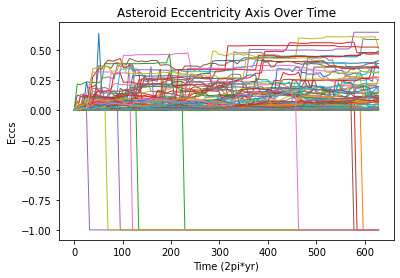

In [40]:
plt.clf()
plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,1)]], linewidth=1)
plt.title('Asteroid Eccentricity Axis Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccs')

(array([32.,  4.,  6.,  8.,  5.,  5.,  2.,  3.,  3.,  0.,  1.,  1.,  3.,
         0.,  3.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.]),
 array([0.00178841, 0.02342177, 0.04505514, 0.0666885 , 0.08832187,
        0.10995523, 0.1315886 , 0.15322196, 0.17485533, 0.19648869,
        0.21812205, 0.23975542, 0.26138878, 0.28302215, 0.30465551,
        0.32628888, 0.34792224, 0.36955561, 0.39118897, 0.41282234,
        0.4344557 , 0.45608907, 0.47772243, 0.4993558 , 0.52098916,
        0.54262252, 0.56425589, 0.58588925, 0.60752262, 0.62915598,
        0.65078935]),
 <BarContainer object of 30 artists>)

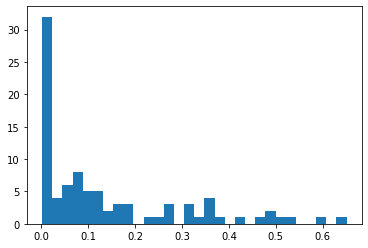

In [51]:
plt.clf()
num_bins = 30
plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
plt.savefig("Figures/"+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")

NameError: name 'seed' is not defined

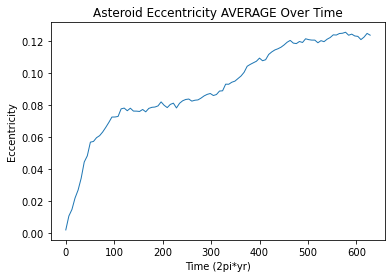

In [48]:
plt.clf()
plt.plot(times, [avg(EccsList, positive = True) for EccsList in asteroidEccs],linewidth=1)
plt.title('Asteroid Eccentricity AVERAGE Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccentricity')
plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")

(array([32.,  4.,  6.,  8.,  5.,  5.,  2.,  3.,  3.,  0.,  1.,  1.,  3.,
         0.,  3.,  1.,  4.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.]),
 array([0.00178841, 0.02342177, 0.04505514, 0.0666885 , 0.08832187,
        0.10995523, 0.1315886 , 0.15322196, 0.17485533, 0.19648869,
        0.21812205, 0.23975542, 0.26138878, 0.28302215, 0.30465551,
        0.32628888, 0.34792224, 0.36955561, 0.39118897, 0.41282234,
        0.4344557 , 0.45608907, 0.47772243, 0.4993558 , 0.52098916,
        0.54262252, 0.56425589, 0.58588925, 0.60752262, 0.62915598,
        0.65078935]),
 <BarContainer object of 30 artists>)

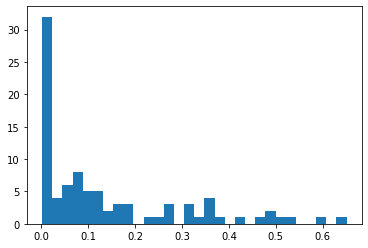

In [43]:
plt.clf()
num_bins =30
plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)

In [30]:
asteroidEccs

array([[0.00213095, 0.00227771, 0.00214434, ..., 0.00236732, 0.00212638,
        0.00163729],
       [0.00442119, 0.00427359, 0.00633507, ..., 0.0026959 , 0.00239909,
        0.0171412 ],
       [0.00239071, 0.00547465, 0.00531342, ..., 0.00245213, 0.00489385,
        0.02208477],
       ...,
       [0.39598914, 0.2095822 , 0.07939152, ..., 0.00702561, 0.31621795,
        0.14940208],
       [0.40471268, 0.20659113, 0.08032478, ..., 0.0030262 , 0.31651619,
        0.18105338],
       [0.4137051 , 0.19297719, 0.08334997, ..., 0.00249092, 0.31103032,
        0.1853824 ]])

Text(0, 0.5, 'Semi Major Axis (AU)')

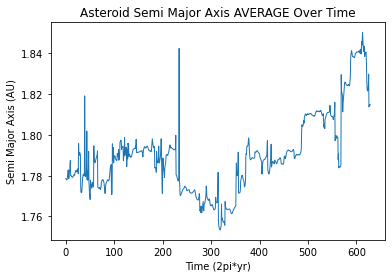

In [6]:
asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
plt.plot(times, asteroidAUaverage,linewidth=1)
plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Semi Major Axis (AU)')
#plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids

In [7]:
asteroidAUaverage = [avg(asteroidAUList) for asteroidAUList in asteroidAU]
asteroidAUaverage

[1.7785390782304518,
 1.7783406705292242,
 1.7780823035095505,
 1.7778878820771908,
 1.7780302210954775,
 1.7787941326966044,
 1.7799007717273903,
 1.781516799435002,
 1.7828486533593275,
 1.7785255972843288,
 1.778679323509837,
 1.7790439579096828,
 1.7824841165817602,
 1.7821660045375651,
 1.7859491091935835,
 1.7875240862716937,
 1.7800669138230247,
 1.7799214278495692,
 1.7799853234123975,
 1.7796564948198108,
 1.7794015525212534,
 1.779278424459155,
 1.779183089207437,
 1.7792449902790437,
 1.7795822126307002,
 1.7799686993644337,
 1.7802903051570118,
 1.78050242568058,
 1.7805565716467808,
 1.7802162892688025,
 1.7812677274583575,
 1.7814833831659547,
 1.7818457891744948,
 1.7825295182831502,
 1.7826255713568988,
 1.7820793706723712,
 1.7818137674676964,
 1.7818912481965001,
 1.7822550136568076,
 1.7833403990029248,
 1.7833534205420465,
 1.780977025216176,
 1.795799518096337,
 1.790383801989885,
 1.7899696485480028,
 1.7910994963926512,
 1.7912981214350046,
 1.7909465913990459,
 

array([[2, 4],
       [7, 9]])

Text(0, 0.5, 'sim.N (AU)')

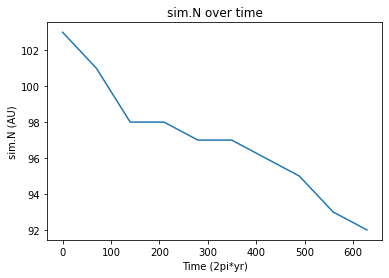

In [43]:
plt.clf()
plt.plot(times, particleNumber)
plt.title('sim.N over time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('sim.N (AU)')
plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")

In [134]:
def animate(N, T, sim): #this makes an animation of a system over time
    sim.integrate(0)
    interval = T/N
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    sim.move_to_com()
    end_timestep = N
    print ('The timestep is ', interval, 'years.')
    #stop = input('Is this suitable? (y/n)')
    #if stop == 'n':
        #sys.exit("Enter a higher N for a lower interval.")
    for i in range(N+1):
        sim.integrate(sim.t+interval)
        #fig, ax = rebound.OrbitPlot(sim,color=True,orbit_type='solid', unitlabel="[AU]",xlim=[-5,5],ylim=[-5,5])
        quickplot(sim)
        display()
        print (i, "timesteps,", i*interval, "years")
        print("The interval is", interval, 'years.')
        """if i == end_timestep/2:
            print("The current timestep is", i, ". This is a time of", i*interval,"years.")
            tf = input("Would you like to continue? (y/n)")
            if tf == 'n':
                break""" #I use these lines if I'm worried the total time is too high
        #plt.close(fig)
        plt.clf()
        clear_output(wait=True)
sim = generatettor(simulation = ttor,seed = None, asteroidnumber = 100)
animate(100,10, sim)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Eccentricity')

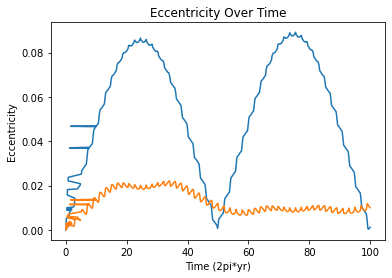

In [206]:
plt.clf()
plt.plot([i/tau for i in times], eccs)
plt.title('Eccentricity Over Time')
plt.xlabel('Time (2pi*yr)')
plt.ylabel('Eccentricity')

In [4]:
import os.path
os.path.isfile("Masslists/appendTest.txt")

True

In [ ]:
import os.path
os.path.isfile(fname)

In [34]:
np.negative(np.ones((2,3)))

array([[-1., -1., -1.],
       [-1., -1., -1.]])

In [35]:
def saveFigs(addOn = "", seed = 0, **kwargs):
    """
    This saves several types of graphs into a folder corresponsing to the seed.
    Optional ability to add on to the name of a file easily.
    NOTE: Depending on the stepnumber, some of these graphs may contain useless data,
    because for some data types the stepnumber needs to be very high.
    """
    if kwargs.get("test"):
        seed = "Tests"
    
    plt.clf() # clears any graphs
    quickplot(sim)
    plt.savefig("Figures/"+str(seed)+"/quickplot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim,slices=0.3,color=True)
    plt.savefig("Figures/"+str(seed)+"/reboundPlot"+addOn+".pdf")
    
    plt.clf()
    rebound.OrbitPlot(sim, slices = .3, color = True, lw = 1, plotparticles = [1,2])
    plt.savefig("Figures/"+str(seed)+"/reboundPlotOnlyPlanets"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, eccs)
    plt.title('Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/Eccentricity"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, relative_x_value)
    plt.title('X Value From Star Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('X Value (AU)')
    plt.savefig("Figures/"+str(seed)+"/relativeXValue"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, masses)
    plt.title('Mass of Planets Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Mass (Solar Masses)')
    plt.savefig("Figures/"+str(seed)+"/masses"+addOn+".pdf")
    
    plt.clf()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Planet Positions')
    axs[0].plot(list(position1[:,0]), list(position1[:,1]),'o')
    axs[1].plot(list(position2[:,0]), list(position2[:,1]),'o')
    axs[0].set_aspect('equal')
    axs[1].set_aspect('equal')
    plt.savefig("Figures/"+str(seed)+"/scatterPlotPositions"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, interplanetdistance)
    plt.title('Interplanetary Distance Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Distance (AU)')
    plt.savefig("Figures/"+str(seed)+"/interplanetaryDistance"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, particleNumber)
    plt.title('sim.N over time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('sim.N (AU)')
    plt.savefig("Figures/"+str(seed)+"/particleNumber"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidEccs[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    plt.title('Asteroid Eccentricity Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccs')
    plt.savefig("Figures/"+str(seed)+"/RoidEccs"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(EccsList, positive = True) for EccsList in asteroidEccs],linewidth=1)
    plt.title('Asteroid Eccentricity AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Eccentricity')
    plt.savefig("Figures/"+str(seed)+"/RoidEccsAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins = 30
    plt.hist([data for data in asteroidEccs[-1] if data >= 0], num_bins)
    plt.title("Asteroids Final Eccentricity Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidEccsHistoEnd"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, asteroidAU[:,[i for i in range(0,simNi-2-1,10)]], linewidth=1)
    # Does not plot every asteroid
    plt.title('Asteroid Semi Major Axis Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.ylim(bottom=-.3, top = 5) # Only want to graph part of escaping asteroids
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxis"+addOn+".pdf")
    
    plt.clf()
    plt.plot(times, [avg(asteroidAUList) for asteroidAUList in asteroidAU],linewidth=1)
    plt.title('Asteroid Semi Major Axis AVERAGE Over Time')
    plt.xlabel('Time (2pi*yr)')
    plt.ylabel('Semi Major Axis (AU)')
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisAverage"+addOn+".pdf")
    
    plt.clf()
    num_bins =30
    plt.hist([data for data in asteroidAU[0] if data > 0 and data < 5], num_bins)
    plt.title("Asteroids Beginning SM-Axis Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoStart"+addOn+".pdf")
    
    plt.clf()
    plt.hist([data for data in asteroidAU[-1] if data > 0 and data < 5], num_bins)
    plt.title("Asteroids Ending SM-Axis Histogram")
    plt.savefig("Figures/"+str(seed)+"/RoidSMAxisHistoEnd"+addOn+".pdf")

array([[1., 1., 1.],
       [1., 1., 1.]])

Steps: 100
Beginning seed 0.
| 0.0 time = 0.0 years | 8 particles | 0 step number |
| 0.0 second | 0.0 minutes.

| 0.6346651825433925 time = 0.10101010101010101 years | 8 particles | 1 step number |
| 0.0 second | 0.0 minutes.

| 1.269330365086785 time = 0.20202020202020202 years | 8 particles | 2 step number |
| 0.0 second | 0.0 minutes.

| 1.9039955476301778 time = 0.30303030303030304 years | 8 particles | 3 step number |
| 0.0 second | 0.0 minutes.

| 2.53866073017357 time = 0.40404040404040403 years | 8 particles | 4 step number |
| 0.0 second | 0.0 minutes.

| 3.1733259127169626 time = 0.5050505050505051 years | 8 particles | 5 step number |
| 0.0 second | 0.0 minutes.

| 3.8079910952603555 time = 0.6060606060606061 years | 8 particles | 6 step number |
| 0.0 second | 0.0 minutes.

| 4.4426562778037475 time = 0.7070707070707071 years | 8 particles | 7 step number |
| 0.0 second | 0.0 minutes.

| 5.07732146034714 time = 0.8080808080808081 years | 8 particles | 8 step number |
| 0.0

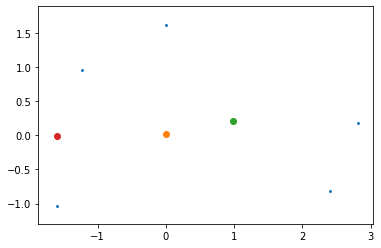

In [11]:
endTime = 10
a = 0
#
#for a in range(numberOfSims):
stepFrequency = .1 # how often should a step occur (years)
steps = int(endTime/stepFrequency) # Will round down to an integer
print(f"Steps: {steps}")
print("Beginning seed {}.".format(a))
sim = generatettor(simulation = ttor, seed =a, asteroidnumber = 5)
quickcollect2(n=2, Ti = 0 * tau, Tf=endTime * tau, stepnumber = steps, asteroidCollect = True)


In [12]:
print(asteroidAU)

[[1.85858814 1.9824141  1.57148554 1.60299423 2.81023766]
 [1.85794211 1.98206444 1.56993117 1.60479907 2.81057514]
 [1.85683559 1.9826591  1.56747295 1.60659606 2.81077769]
 [1.85538236 1.98316008 1.56555734 1.60829014 2.81090284]
 [1.8548424  1.98331577 1.56650955 1.60974551 2.81101259]
 [1.85525683 1.98327516 1.56755796 1.61075939 2.81113491]
 [1.8553476  1.98319003 1.56766844 1.61103629 2.81125247]
 [1.85498847 1.98317203 1.56714746 1.61056788 2.81129952]
 [1.85437424 1.98329372 1.56627053 1.61147158 2.81116565]
 [1.8536709  1.98358813 1.56521666 1.61430442 2.81071479]
 [1.85299895 1.98404746 1.56411053 1.61661469 2.80986536]
 [1.8524405  1.98462355 1.56304289 1.6181443  2.8088174 ]
 [1.85204143 1.98523016 1.56207725 1.61918005 2.80803188]
 [1.85181186 1.98574339 1.56125214 1.6199283  2.80774635]
 [1.85172693 1.98600048 1.56058241 1.62052528 2.80810238]
 [1.8517268  1.98586187 1.56005949 1.62106895 2.8088979 ]
 [1.85171433 1.98570197 1.55965051 1.62163187 2.80973072]
 [1.85154769 1

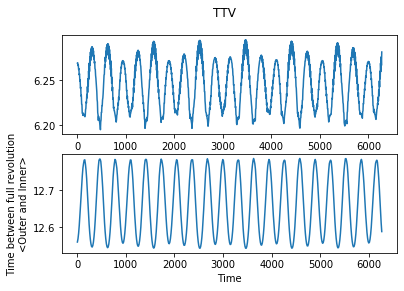

In [178]:
def ttvLinearApprox(data, times):
    """
    Transit timing variation. Detects the time at which the planet crosses the
    positive x-axis. 
    """
    global innertimes, outertimes
    innertimes = []
    outertimes = []
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        # Deleting the last row is one way to avoid an index error
        if x[0] < 0 and data[i+1][0] > 0: #for inner planet
            slope = (data[i+1][0]-data[i][0])/(times[i+1]-times[i])
            linearApprox = times[i+1]-data[i+1][0]/slope
            #(times[i]+times[i+1])/2
            innertimes.append(linearApprox)
        if x[1] < 0 and data[i+1][1] > 0: #for outer planet
            #averageT = (times[i]+times[i+1])/2
            slope = (data[i+1][1]-data[i][1])/(times[i+1]-times[i])
            linearApprox = times[i+1]-data[i+1][1]/slope
            outertimes.append(linearApprox)
            
    # The following measures the time difference between each succesive transit.
    global innertimesdif, outertimesdif
    innertimesdif = []
    for i in range(1,len(innertimes)):
        dif = innertimes[i]-innertimes[i-1]
        innertimesdif.append(dif)
    outertimesdif = []
    for i in range(1,len(outertimes)):
        dif = outertimes[i]-outertimes[i-1]
        outertimesdif.append(dif)
        
    # Graphs the difference with respect to the simulation time in which it occured.
    fig, axs = plt.subplots(2,1)
    fig.suptitle('TTV')
    axs[0].plot(innertimes[:len(innertimes)-1], innertimesdif)
    axs[1].plot(outertimes[:len(outertimes)-1], outertimesdif)
    plt.xlabel('Time')
    plt.ylabel('Time between full revolution\n<Outer and Inner>')
end = None
ttvLinearApprox(relative_y_value[0:end],times[0:end])

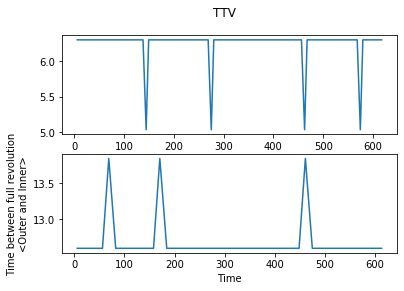

In [158]:
def ttv(data, times):
    """
    Transit timing variation. Detects the time at which the planet crosses the
    positive x-axis. 
    """
    global innertimes, outertimes
    innertimes = []
    outertimes = []
    for i, x in enumerate(np.delete(data,len(data)-1,0)):
        # Deleting the last row is one way to avoid an index error
        if x[0] < 0 and data[i+1][0] > 0: #for inner planet
            averageT = (times[i]+times[i+1])/2
            innertimes.append(averageT)
        if x[1] < 0 and data[i+1][1] > 0: #for outer planet
            averageT = (times[i]+times[i+1])/2
            outertimes.append(averageT)
            
    # The following measures the time difference between each succesive transit.
    global innertimesdif, outertimesdif
    innertimesdif = []
    for i in range(1,len(innertimes)):
        dif = innertimes[i]-innertimes[i-1]
        innertimesdif.append(dif)
    outertimesdif = []
    for i in range(1,len(outertimes)):
        dif = outertimes[i]-outertimes[i-1]
        outertimesdif.append(dif)
        
    # Graphs the difference with respect to the simulation time in which it occured.
    fig, axs = plt.subplots(2,1)
    fig.suptitle('TTV')
    axs[0].plot(innertimes[:len(innertimes)-1], innertimesdif)
    axs[1].plot(outertimes[:len(outertimes)-1], outertimesdif)
    plt.xlabel('Time')
    plt.ylabel('Time between full revolution\n<Outer and Inner>')
ttv(relative_y_value,times)

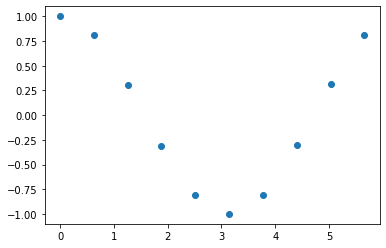

In [170]:
plt.plot(times[0:10],relative_x_value[0:10,0], 'o')

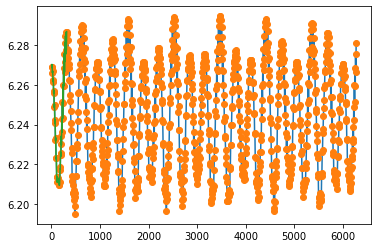

In [171]:
end = None
from scipy.interpolate import interp1d
plt.plot(innertimes[:len(innertimes)-1][0:end], innertimesdif[0:end])
plt.plot(innertimes[:len(innertimes)-1][0:end], innertimesdif[0:end],'o')
f2 = interp1d(innertimes[:len(innertimes)-1], innertimesdif, kind='cubic')
x = innertimes[:len(innertimes)-1][0:50]
xnew = np.linspace(x[0], x[-1], num=10000, endpoint=True)
plt.plot(xnew, f2(xnew), '-')

[-0.03894983  0.01931102 -1.19161482  6.24592119]


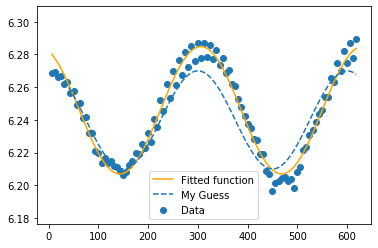

In [176]:
###############################
# I learned it was important to fine tune p0 if the optimize function gave bad params
###############################
from scipy import optimize
x_data, y_data = innertimes[:len(innertimes)-1][0:end], innertimesdif[0:end]
def test_func(x, a, b,c,d):
    return a * np.sin(b * x + c)+d

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,#,
        p0=[-.03,1/300*2*np.pi,-np.pi/2,6.24])
print(params)


plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, test_func(x_data, params[0], params[1], params[2]),
#          label='Fitted function')

plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
         label='Fitted function', color = 'orange')
params = [-.03,1/300*2*np.pi,-np.pi/2,6.24]
plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
        "--",label = "My Guess")

plt.legend(loc='best')

plt.show()

[-0.03625166  0.12492456 -1.48494307  6.24455576]


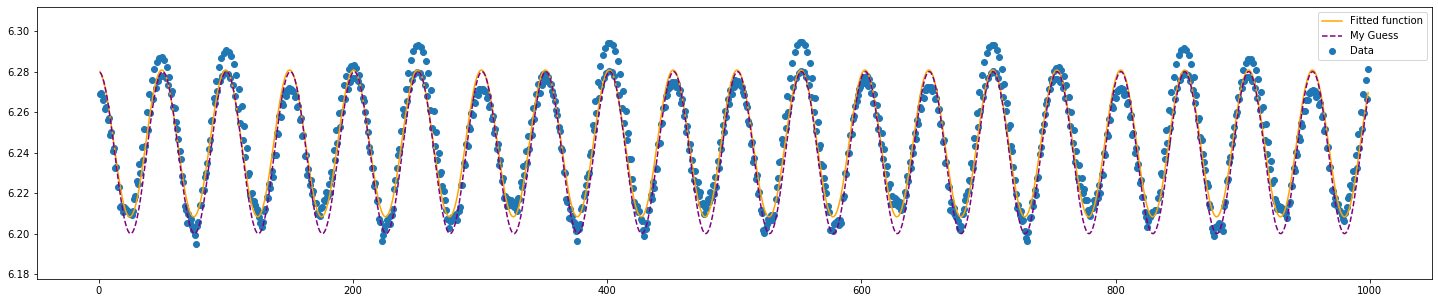

In [230]:
end = None
from scipy import optimize
x_data, y_data = [time/tau for time in innertimes[:len(innertimes)-1][0:end]], innertimesdif[0:end]
def test_func(x, a, b,c,d):
    return a * np.sin(b * x + c)+d

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
        p0=[-.04,1/8,-np.pi/2,6.24])
print(params)


plt.figure(figsize=(25, 5))
plt.scatter(x_data, y_data, label='Data')
# plt.plot(x_data, test_func(x_data, params[0], params[1], params[2]),
#          label='Fitted function')

plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
         label='Fitted function', color = 'orange')
params = [-.04,1/8,-np.pi/2,6.24]
plt.plot(x_data, [test_func(x, params[0], params[1], params[2],params[3]) for x in x_data],
        "--",label = "My Guess", color = 'purple')

plt.legend(loc='best')

plt.show()

In [188]:
innertimes[100]

630.6858227034372